In [1]:
import torch as torch
from network.metric.accuracy import acc_srcnn_tiny_radar
from network.models.classifiers.tiny_radar import TinyRadarNN
from network.models.sr_classifier.SRCnnTinyRadar import CombinedSRCNNClassifier
from network.models.super_resolution.drln import DRLN
from network.models.super_resolution.srcnn import SRCnn
from network.runner import Runner
from utils.utils_paths import get_time_in_string
from utils.utils_images import Normalization
import os
import numpy as np

In [45]:
from network.models.super_resolution import srcnn


def model_dirs(base_dir:str):
    res = []
    for model_arch in os.listdir(base_dir):
        if model_arch == ".DS_Store":
            continue
        if model_arch == "row_8_col_64_d_none_u_cubic":
            continue
        arch_dir = os.path.join(base_dir, model_arch)
        dataset_name = "_row_4_col_4_d_none_u_cubic_normalization.range_neg_1_1"
        dataset_dir = os.path.join(arch_dir, dataset_name)
        for train_cg in os.listdir(dataset_dir):
            if train_cg == ".DS_Store":
                continue
            for model in os.listdir(os.path.join(dataset_dir, train_cg)):
                if model == ".DS_Store":
                    continue
                if "max_acc" in model:
                    res.append(os.path.join(dataset_dir, train_cg, model))
    return res

def get_model(model_dir,num_filters, k, activation):
    tiny_radar = TinyRadarNN()
    srcnn = SRCnn(
        num_features_1=num_filters,
        num_features_2=num_filters,
        kernel_size=(k,k),
        activation=activation,
    )
    model = CombinedSRCNNClassifier(srcnn, tiny_radar)
    model.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))
    model.eval()
    return model



In [85]:
def pixel_range(img, desc):
    min_val = img.min()
    max_val = img.max()
    print(desc + f" pixel range: [{min_val} , {max_val}]")

def plot_img(img, desc):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.title(desc)
    plt.show()

def nom_img(imgs):
    for i in range(imgs.shape[0]):
        for j in range(imgs.shape[1]):
            for k in range(imgs.shape[2]):
                img = imgs[i,j,k,:,:]
                img_max = img.max()
                imgs[i,j,k,:,:] = 2*(img/img_max)-1
    return imgs


class ModelResult:
    def __init__(self, model_path:str):
        self.model_path = model_path
        self.get_model_info()
        self.model = get_model(model_path, int(self.num_filters), int(self.kernel_size[1]), self.activation)
        # self.model.eval()
    
    def get_model_info(self):
        params = self.model_path.split("/")
        model_arch = params[-4]
        self.num_filters = model_arch.split("_")[4]
        self.kernel_size = model_arch.split("_")[10]
        self.activation = model_arch.split("_")[12]
        if self.activation == "leaky":
            self.activation = "leaky_relu"
        train_cg = params[-2]
        self.lr = train_cg.split("_")[1]
        self.sr_loss = train_cg.split("_")[7]
        self.sr_wight = train_cg.split("_")[12]
        self.c_wight = train_cg.split("_")[15]
    
    def plot_res(self,low_res_imgs,hight_res_imgs, label):
        print(self)        

        res = self.model(low_res_imgs[:5])
        res_imgs = res[0].detach().numpy()
        low_res_img = low_res_imgs[0,0,0,:,:]
        higit_res_img_true = hight_res_imgs[0,0,0,:,:]
        higit_res_img_pred = res_imgs[0,0,0,:,:]

        print(label)
        pixel_range(low_res_img, "low res")
        pixel_range(higit_res_img_true, "hight res true")
        pixel_range(higit_res_img_pred, "hight res pred")
        mse1 = np.square(higit_res_img_true - higit_res_img_pred).mean()
        print("mse true - pred: ", mse1)
        mse2 = np.square(higit_res_img_true - low_res_img).mean()
        print("mse true - lr: ", mse2)
        plot_img(low_res_img, "low res")
        plot_img(higit_res_img_true, "hight res true")
        plot_img(higit_res_img_pred, "hight res pred")

    
    def __str__(self) -> str:
        model_arc_f = f"num_filters: {self.num_filters}, kernel_size: {self.kernel_size}, activation: {self.activation}"
        train_cg_f = f"lr: {self.lr}, sr_loss: {self.sr_loss}, sr_wight: {self.sr_wight}, c_wight: {self.c_wight}"
        return model_arc_f + "\n" + train_cg_f

In [80]:
base_path = "/Users/netanelblumenfeld/Desktop/bgu/Msc/project/outputs/models/sr_classifier"
res = model_dirs(base_path)
r = ModelResult(res[4])
print(r)

num_filters: 32, kernel_size: (3, 3), activation: leaky_relu
lr: 0.001, sr_loss: 1, sr_wight: 0, sr_loss: 1


SRCNN - TinyRadarNN results - 

In [81]:
from data_loader.tiny_radar_loader import tiny_radar_for_sr_classifier_on_disk


gestures = [
        "PinchIndex",
        "PinchPinky",
        "FingerSlider",
        "FingerRub",
        "SlowSwipeRL",
        "FastSwipeRL",
        "Push",
        "Pull",
        "PalmTilt",
        "Circle",
        "PalmHold",
        "NoHand",
    ]
persons = 2
people = list(range(1, persons, 1))
data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"
high_res_dir = data_dir + "data_feat/"
low_res_dir = data_dir + "_row_4_col_4_d_none_u_cubic/"
batch_size = 64
training_generator,val_generator,dataset_name, = tiny_radar_for_sr_classifier_on_disk(
            high_res_dir,
            low_res_dir,
            people,
            gestures,
            batch_size,
            Normalization.Range_neg_1_1, # type: ignore
        )


Doing 1
Doing 1


In [82]:
for low_res_imgs, y in training_generator:
    hight_res_imgs = y[0]
    label = y[1]
    break

In [83]:
label.shape

torch.Size([64, 5])

num_filters: 32, kernel_size: (7, 7), activation: leaky_relu
lr: 0.001, sr_loss: MSE, sr_wight: 1, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-1.0422286987304688 , 0.4013504385948181]
mse true - pred:  tensor(0.0051)
mse true - lr:  tensor(0.0009)


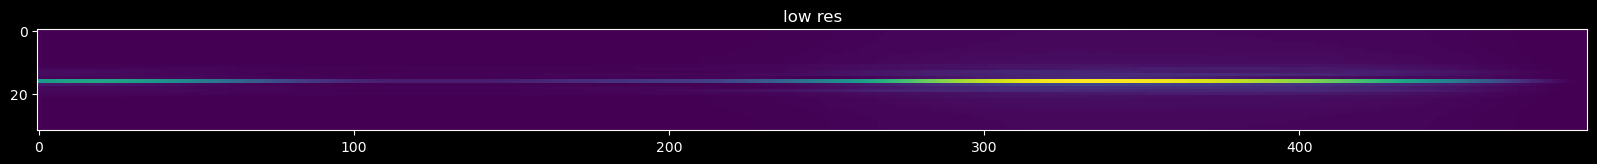

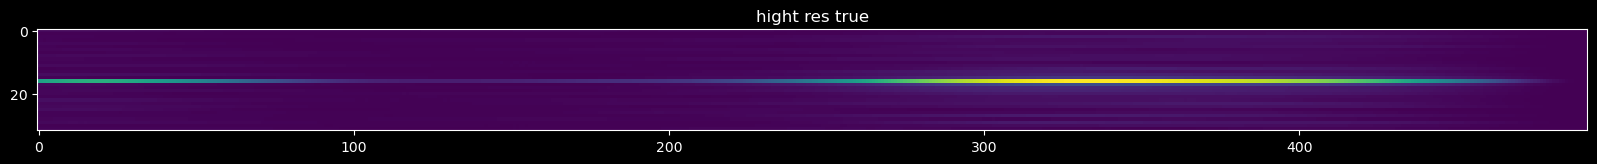

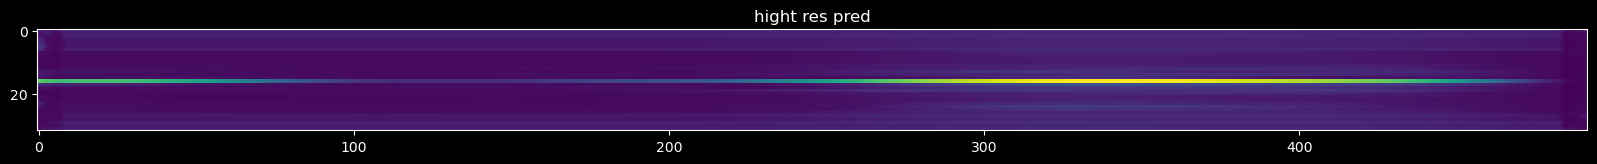

num_filters: 32, kernel_size: (7, 7), activation: leaky_relu
lr: 0.001, sr_loss: L1, sr_wight: 1, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-1.0063873529434204 , 0.6190571784973145]
mse true - pred:  tensor(0.0022)
mse true - lr:  tensor(0.0009)


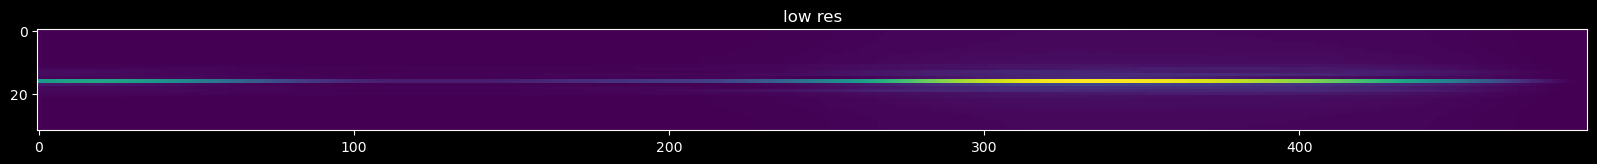

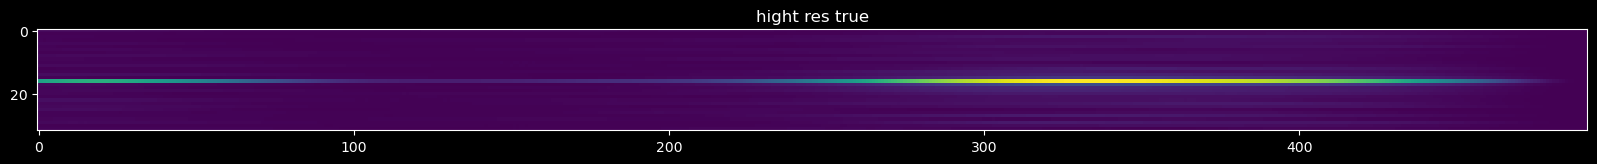

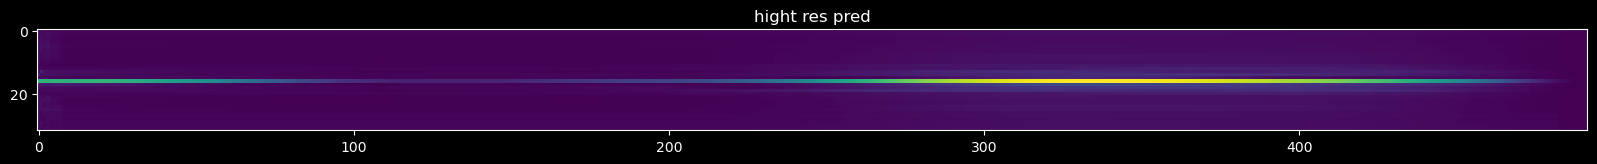

num_filters: 32, kernel_size: (3, 3), activation: leaky_relu
lr: 0.001, sr_loss: MSE, sr_wight: 1, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-1.0219614505767822 , 0.4619465470314026]
mse true - pred:  tensor(0.0052)
mse true - lr:  tensor(0.0009)


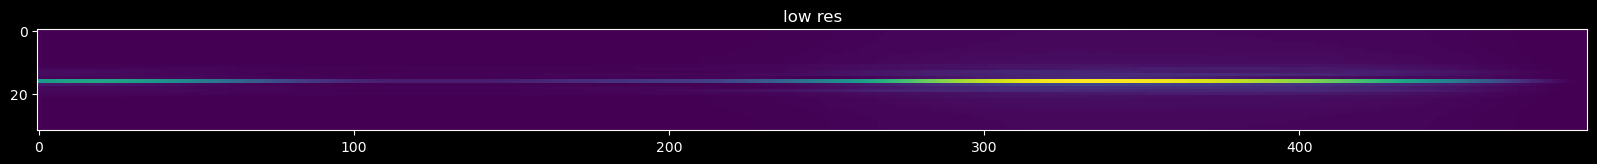

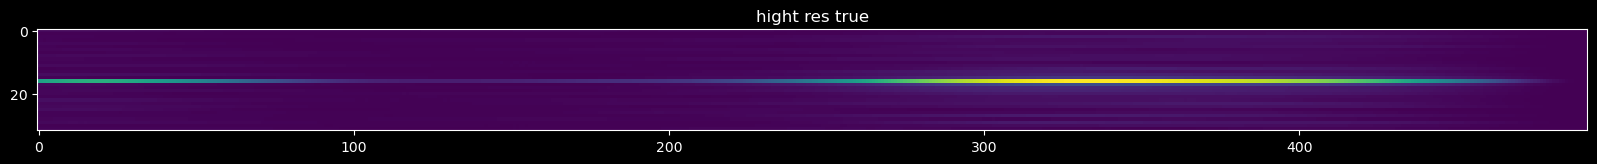

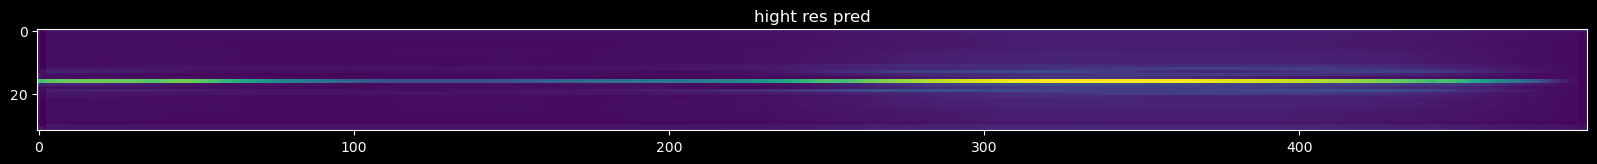

num_filters: 32, kernel_size: (3, 3), activation: leaky_relu
lr: 0.001, sr_loss: MSE, sr_wight: 0, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-0.42808282375335693 , 1.2575812339782715]
mse true - pred:  tensor(0.6455)
mse true - lr:  tensor(0.0009)


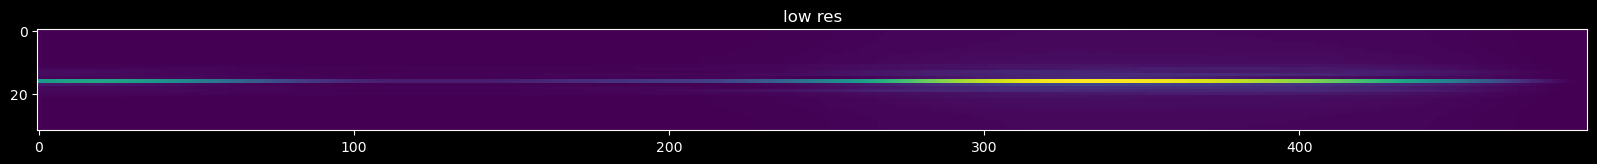

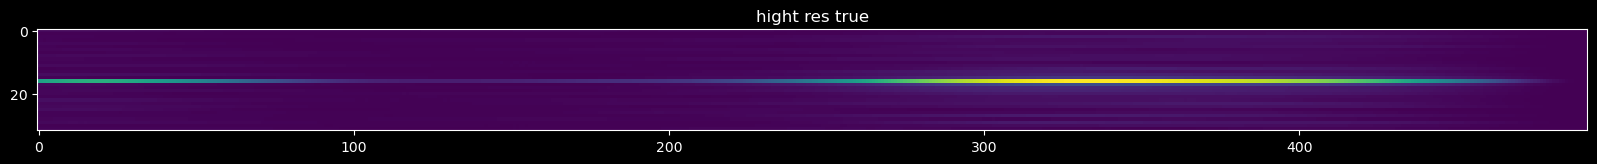

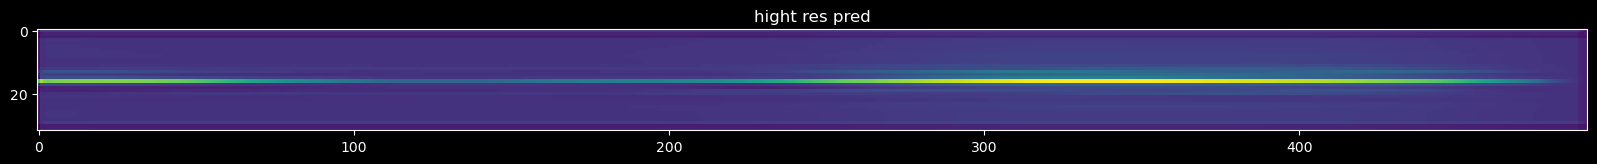

num_filters: 32, kernel_size: (3, 3), activation: leaky_relu
lr: 0.001, sr_loss: L1, sr_wight: 0, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-0.5947049260139465 , 1.2145580053329468]
mse true - pred:  tensor(0.5225)
mse true - lr:  tensor(0.0009)


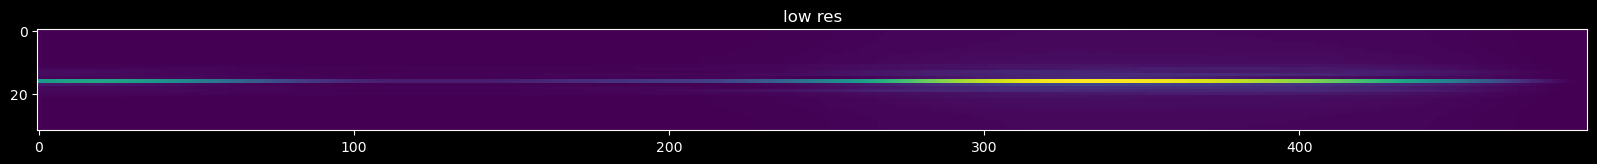

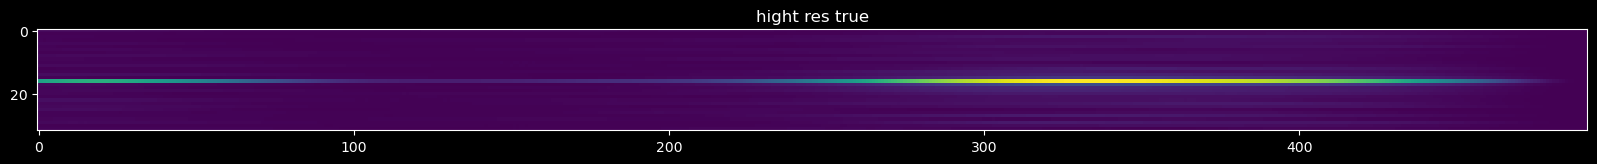

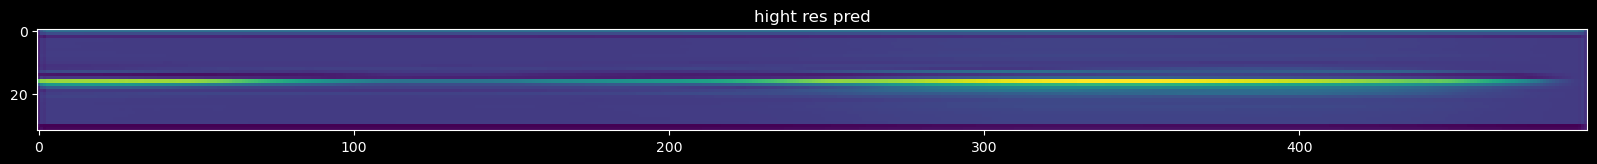

num_filters: 32, kernel_size: (3, 3), activation: leaky_relu
lr: 0.001, sr_loss: L1, sr_wight: 1, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-1.006192922592163 , 0.5150595903396606]
mse true - pred:  tensor(0.0032)
mse true - lr:  tensor(0.0009)


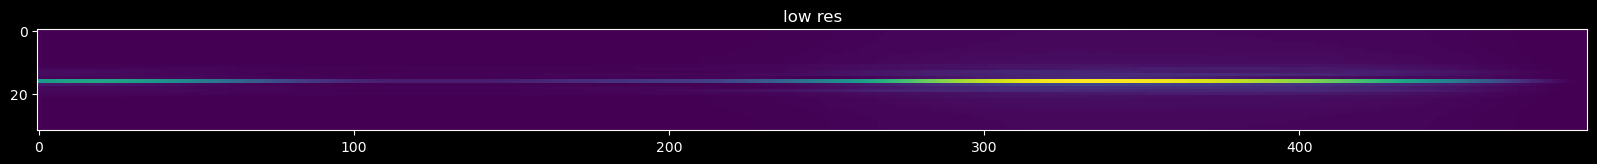

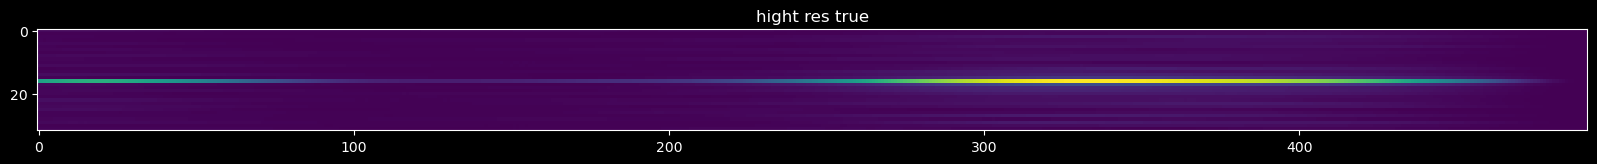

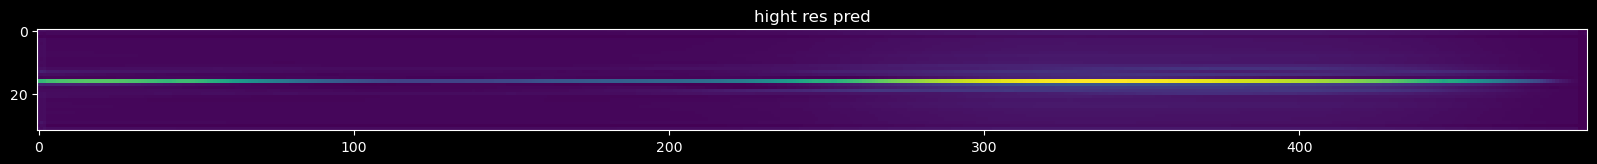

num_filters: 32, kernel_size: (7, 7), activation: elu
lr: 0.001, sr_loss: MSE, sr_wight: 1, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-2.0 , 0.0]
mse true - pred:  tensor(1.0170)
mse true - lr:  tensor(0.0009)


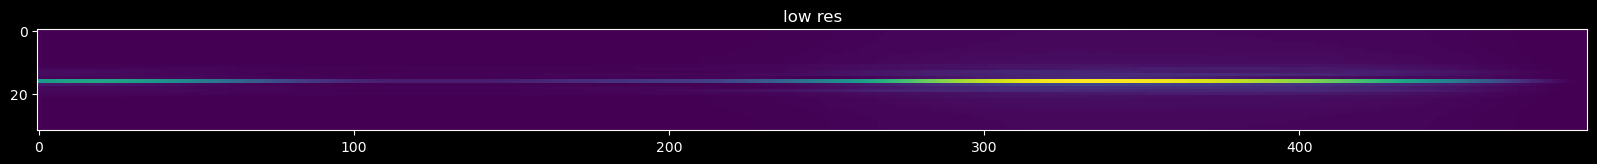

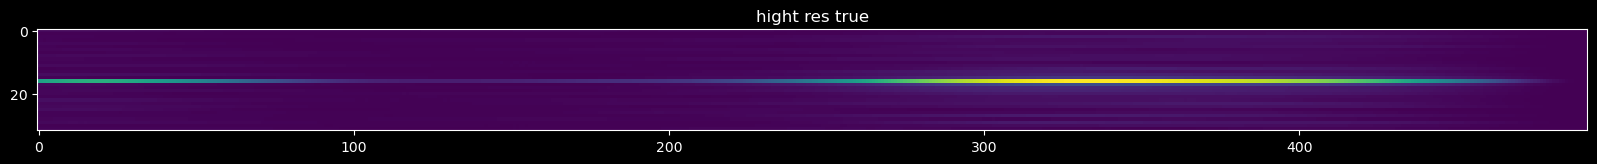

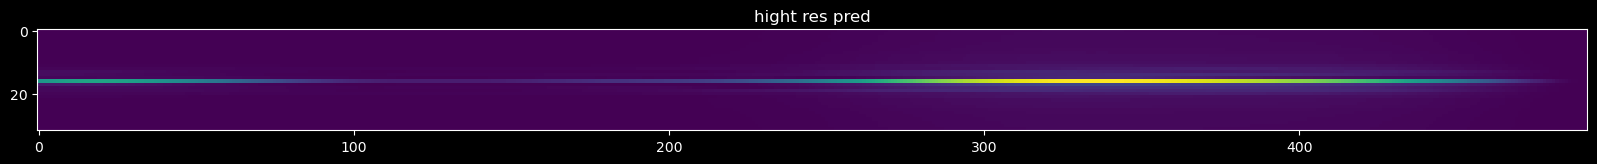

num_filters: 32, kernel_size: (7, 7), activation: elu
lr: 0.001, sr_loss: L1, sr_wight: 1, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-1.134324550628662 , 0.9543891549110413]
mse true - pred:  tensor(0.0009)
mse true - lr:  tensor(0.0009)


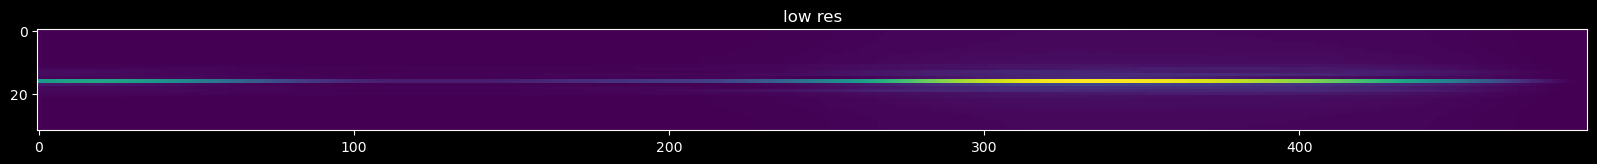

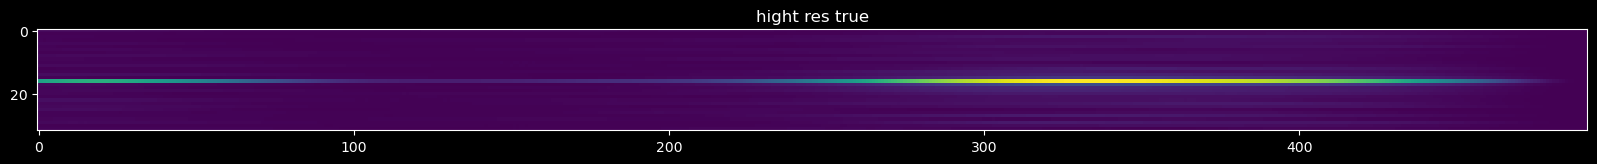

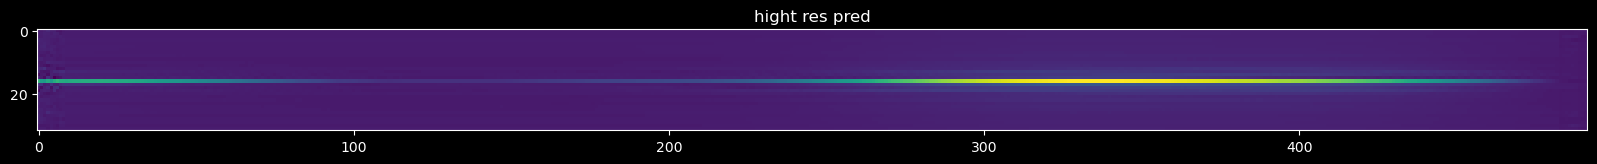

num_filters: 32, kernel_size: (3, 3), activation: elu
lr: 0.001, sr_loss: MSE, sr_wight: 1, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-1.1611835956573486 , 0.4882602095603943]
mse true - pred:  tensor(0.0054)
mse true - lr:  tensor(0.0009)


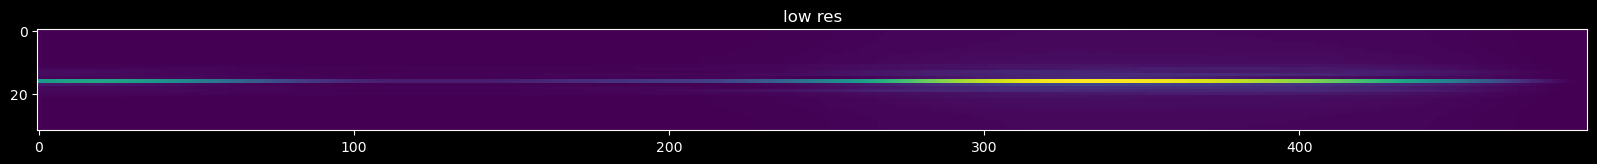

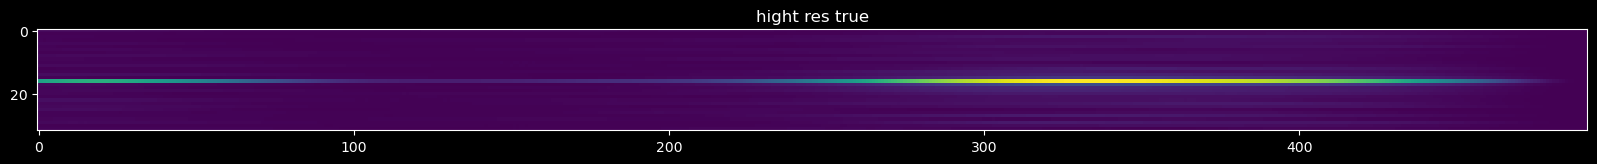

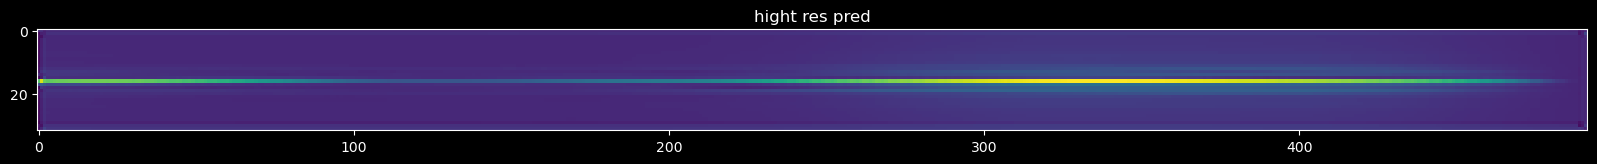

num_filters: 32, kernel_size: (3, 3), activation: elu
lr: 0.001, sr_loss: L1, sr_wight: 1, c_wight: 1
tensor(10)
low res pixel range: [-1.0 , 1.0]
hight res true pixel range: [-1.0 , 1.0]
hight res pred pixel range: [-1.0693261623382568 , 0.5589847564697266]
mse true - pred:  tensor(0.0029)
mse true - lr:  tensor(0.0009)


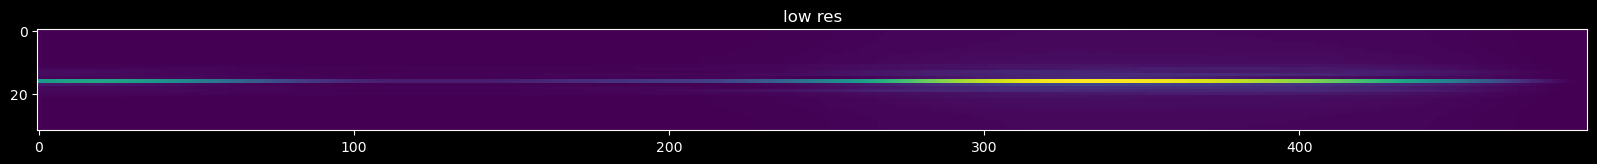

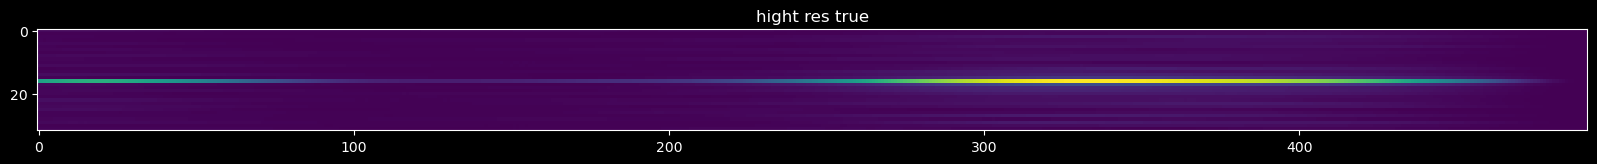

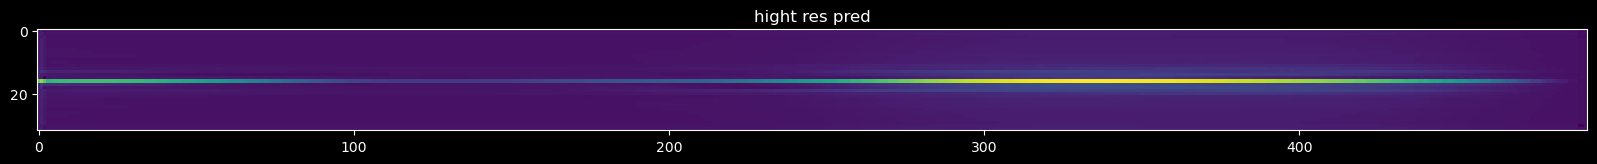

In [86]:
for i in range(10):
    k=0
    r = ModelResult(res[i])
    r.plot_res(low_res_imgs,hight_res_imgs, label[k,k])
